## Imports

In [83]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tools.eval_measures import rmse
from prophet.plot import add_changepoints_to_plot
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [84]:
df = pd.read_csv('data_cleaned.csv', parse_dates=['date'])

In [85]:
pd.set_option('display.max_columns', None)

## Time Series Creation Functions

In [86]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'profit':'net_profit'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [87]:
def create_ts_dt_feat(ts_df):
    ts_df['year'] = ts_df['date'].dt.year
    ts_df['month'] = ts_df['date'].dt.month
    ts_df['day'] = ts_df['date'].dt.day
    ts_df['weekofyear'] = ts_df['date'].dt.week
    ts_df['weekday'] = ts_df['date'].dt.weekday
    ts_df['weekday'] = np.where(ts_df.weekday == 0, 7, ts_df.weekday)
    return ts_df

In [88]:
def create_ts_lag_feat(ts_df, start, n_lag):
    for lag in range(start, n_lag+1):
        ts_df[f'lag_{lag}'] = ts_df.iloc[:, 1].shift(lag)
    ts_df = ts_df.iloc[n_lag: , :]
    return ts_df

In [89]:
def create_month_revenue_plot_per_cat(df, coltype, catlist):
    df_list = []
    for cat in catlist:
        tmp = df[df[coltype] == cat]
        tmp = select_series(tmp, 'month', 'net')
        tmp[coltype] = cat
        df_list.append(tmp)
    final_df = pd.concat(df_list).reset_index()
    sns.lineplot(data=final_df, x="date", y="net_revenue", hue=f"{coltype}")
    return final_df

## Data Prep and Feature Engineering

In [90]:
filters = df['group1'] == 'Running shoes'
df = df[filters]

In [91]:
df=select_series(df, 'day', 'net')

In [92]:
df.columns=['ds', 'y']

In [93]:
train = df[df['ds'] < pd.Timestamp('2021-06-01')]
test = df[df['ds'] >= pd.Timestamp('2021-06-01')]

In [94]:
print(f"Train date range: {train['ds'].min()} to {train['ds'].max()}")

Train date range: 2019-06-01 00:00:00 to 2021-05-31 00:00:00


In [95]:
print(f"Test date range: {test['ds'].min()} to {test['ds'].max()}")

Test date range: 2021-06-01 00:00:00 to 2022-01-14 00:00:00


## Prophet Initial Model

In [96]:
m = Prophet(daily_seasonality=False)
m.fit(train)

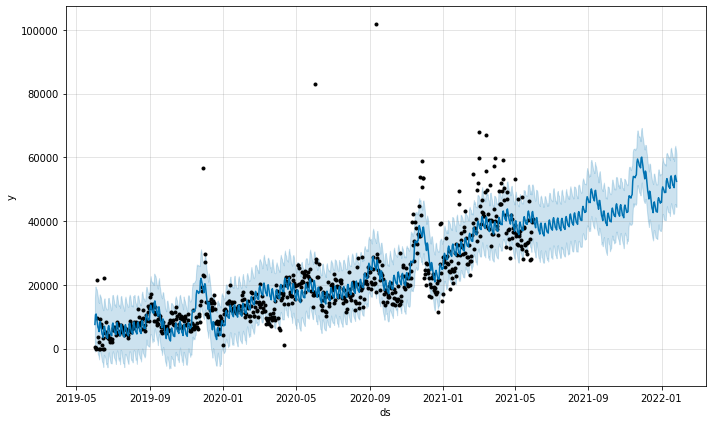

In [97]:
future=m.make_future_dataframe(periods=240, freq='D')
forecast=m.predict(future)
fig=m.plot(forecast)

In [98]:
predictions = forecast.iloc[-len(test):]['yhat']
actuals = test['y']

print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 14162


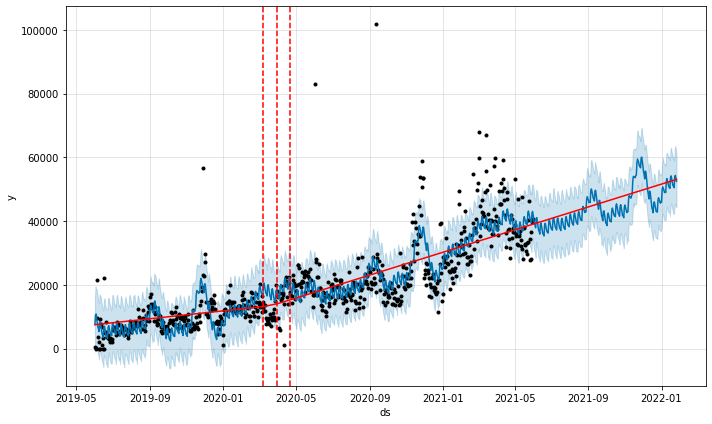

In [99]:
# plot change points
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## Cross Validation

In [100]:
cutoffs=pd.to_datetime(['2021-06-01'])
#cutoffs=cutoffs
df_cv = cross_validation(m, initial='365.25 days', period='30 days', horizon = '240 days', parallel='processes')

INFO:prophet:Making 5 forecasts with cutoffs between 2020-06-05 00:00:00 and 2020-10-03 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa4de78490>


In [101]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,1.087539e+08,10428.515934,6204.009918,0.350902,0.223729,0.277227,0.683333
1,25 days,1.091751e+08,10448.690145,6221.425114,0.351489,0.223729,0.277494,0.683333
2,26 days,1.094599e+08,10462.307393,6285.723780,0.355311,0.223729,0.280896,0.683333
3,27 days,1.099860e+08,10487.422999,6336.212312,0.358672,0.223729,0.283562,0.675000
4,28 days,1.085587e+08,10419.152611,6222.001795,0.351748,0.220645,0.278247,0.683333


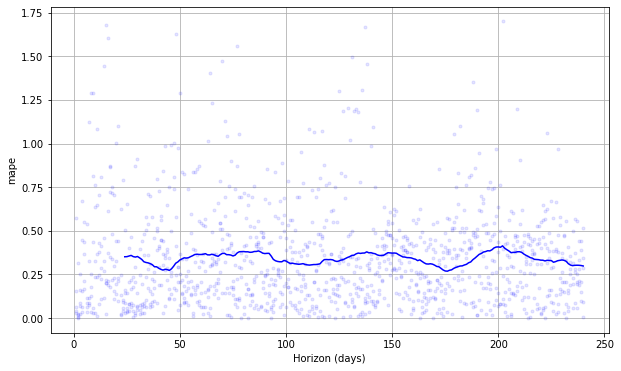

In [102]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

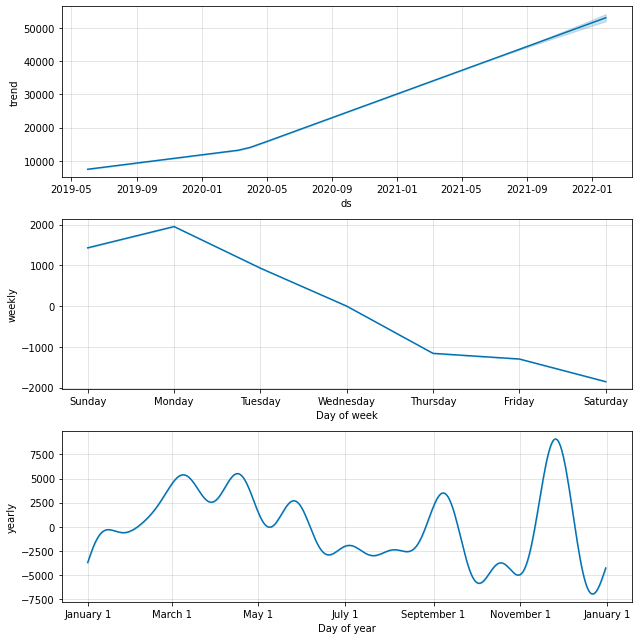

In [103]:
fig=m.plot_components(forecast)

## Hyperparameter Tuning

In [104]:
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.02, 0.1, 1.0, 10.0],
              'seasonality_mode': ['additive', 'multiplicative']}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # store the RMSEs for each params here

In [105]:
# go through all parameter combos
for i in range(len(all_params)):
  
    # create & fit model with given params combo
    m = Prophet(daily_seasonality=False, **all_params[i]).fit(df)
    
    # cross validate the model 
    df_cv = cross_validation(m, 
                             horizon="240 days",
                             period="30 days", 
                             initial="365.25 days", 
                             parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    # pull rmse and add it to the list
    rmses.append(df_p['rmse'].values[0])

INFO:prophet:Making 12 forecasts with cutoffs between 2020-06-23 00:00:00 and 2021-05-19 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa546d08e0>
INFO:prophet:Making 12 forecasts with cutoffs between 2020-06-23 00:00:00 and 2021-05-19 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa56489070>
INFO:prophet:Making 12 forecasts with cutoffs between 2020-06-23 00:00:00 and 2021-05-19 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa5529f430>
INFO:prophet:Making 12 forecasts with cutoffs between 2020-06-23 00:00:00 and 2021-05-19 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa51671700>
INFO:prophet:Making 12 forecasts with cutoffs between 2020-06-23 00:00:00 and 2021-05-19 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures

In [106]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
best_params= all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


## Best Model

In [115]:
final_m=Prophet(daily_seasonality=False, seasonality_mode='multiplicative', 
                    seasonality_prior_scale=0.0'holidays_prior_scale': 0.01'holidays_prior_scale': 0.011, changepoint_prior_scale=0.001)
final_m.fit(train)

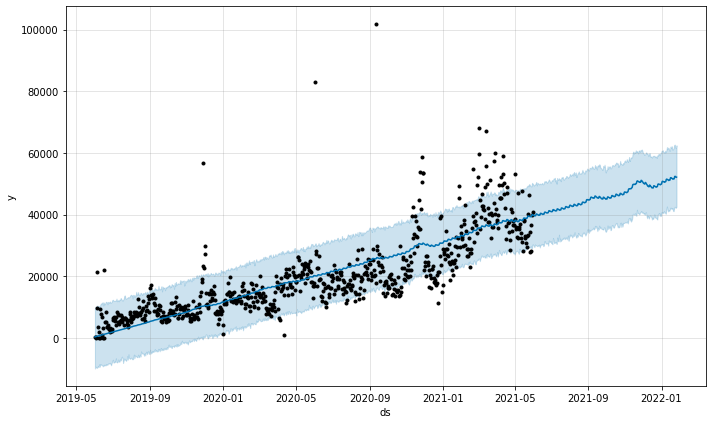

In [116]:
final_future=final_m.make_future_dataframe(periods=240, freq='D')
final_forecast=final_m.predict(final_future)
fig=final_m.plot(final_forecast)

## Best Model Visualization

Text(86.375, 0.5, 'Sales')

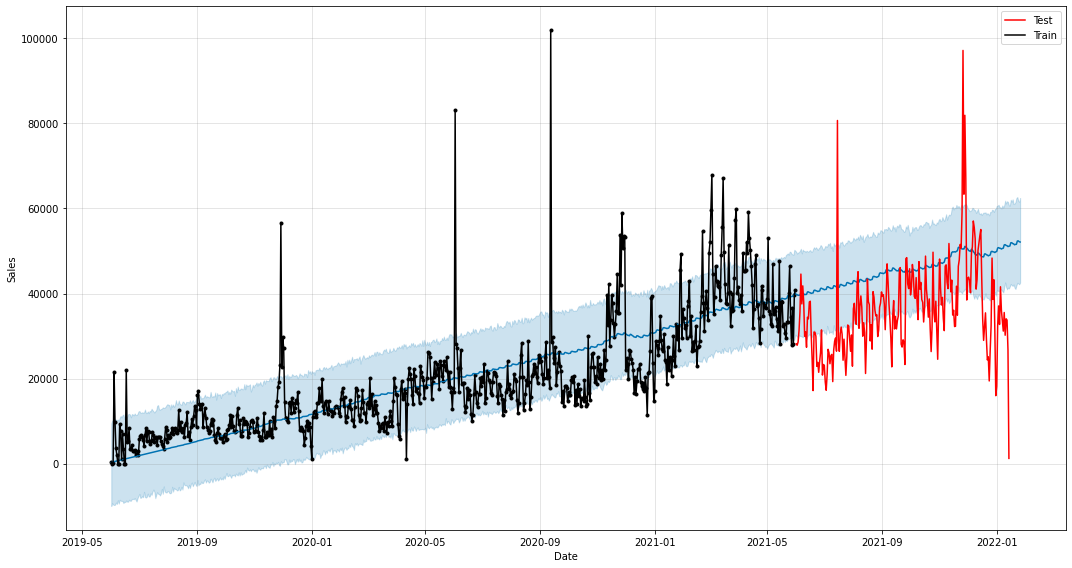

In [117]:
fig, ax=plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)


final_m.plot(final_forecast, ax=ax)
ax.plot(test.ds, test.y, color='r', label='Test')
ax.plot(train.ds, train.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

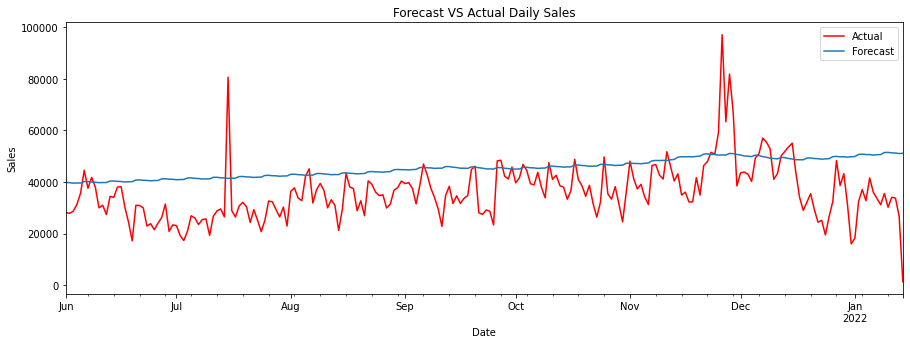

In [118]:
x_test_forecast=final_m.predict(test)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(x='ds', y='y', color='r', label='Actual', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [119]:
predictions = final_forecast.iloc[-len(test):]['yhat']
actuals = test['y']

print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 14423


In [120]:
# import json
# from prophet.serialize import model_to_json, model_from_json

# # Save model
# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)

# # Load model
# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  

## Miscellaneous Final plots

Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

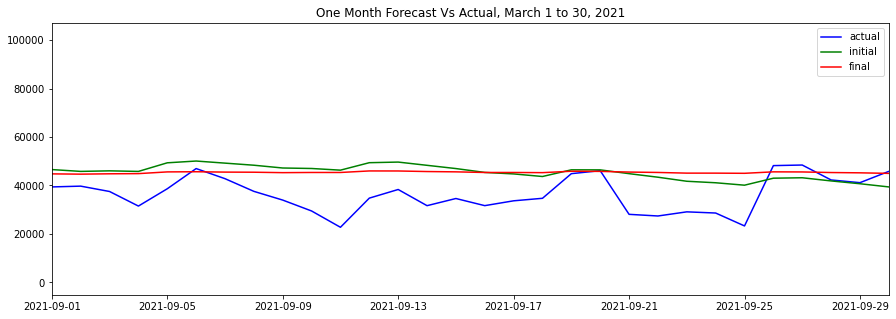

In [121]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
ax.plot(df['ds'], df['y'], color='b', label='actual')
ax.plot(forecast['ds'], forecast['yhat'], color='g', label='initial')
ax.plot(final_forecast['ds'], final_forecast['yhat'], color='r', label='final')
ax.set_xbound(lower=dt.date(2021,9,1), upper=dt.date(2021,9,30))
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

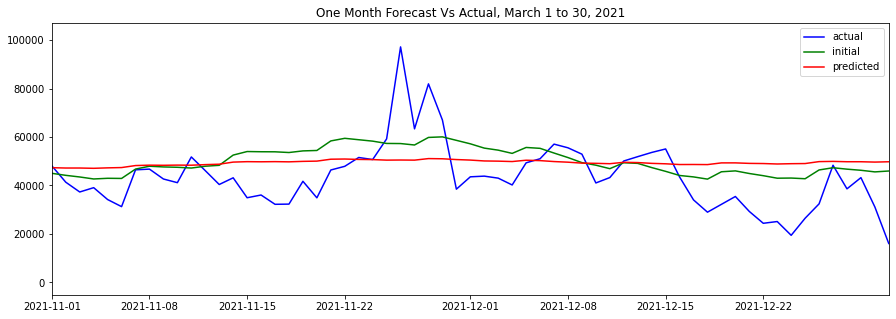

In [122]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
ax.plot(df['ds'], df['y'], color='b', label='actual')
ax.plot(forecast['ds'], forecast['yhat'], color='g', label='initial')
ax.plot(final_forecast['ds'], final_forecast['yhat'], color='r', label='predicted')
ax.set_xbound(lower=dt.date(2021,11,1), upper=dt.date(2021,12,31))
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')